# Reunion Internship Assignment 


### Problem 1: Data Modelling (related to Problem 2)

Imagine you are designing a database for an e-commerce platform. The database should store information about products, customers, orders, etc. (this is only indicative; please feel free to create tables as per your imagination).

Customer details such as shipping address, contact number etc. can change over time. Each product can have multiple variants based on its attributes. Each variant may be launched at various times, then discontinued and then perhaps relaunched later as per the business requirements. Price of the product and its variants may keep on changing with time. We want to retain the historical information for these changes as well in our schema.

**You are required to:**

1. Design a **star-schema / snowflake schema model** for the above requirements
    1. Use an entity-relationship diagram (ERD) that represents the relationships between these entities
    2. Include the necessary attributes and primary/foreign key relationships. Briefly explain your design choices.
2. Generate and insert sample data in the above model. Include the process and code of generating random data in your submission. You data should have:
    1. At least 2 years of order history
    2. At least 10 products; at least 2 products with variants.
    3. At least 10 customers

In [2]:
import sqlite3
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta
import random

# Initialize Faker to generate random data
fake = Faker()

# Create SQLite connection
conn = sqlite3.connect('ecommerce.db')
cursor = conn.cursor()


# Function to create tables
def create_tables():
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS DimDate (
            DateID INTEGER PRIMARY KEY AUTOINCREMENT,
            Date TEXT NOT NULL,
            Year INT,
            Month INT,
            Day INT,
            Quarter INT
        );
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS DimCustomer (
            CustomerID INTEGER PRIMARY KEY AUTOINCREMENT,
            CustomerName TEXT,
            ContactNumber TEXT,
            ShippingAddress TEXT,
            Email TEXT,
            StartDate TEXT,
            EndDate TEXT
        );
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS DimProduct (
            ProductID INTEGER PRIMARY KEY AUTOINCREMENT,
            ProductName TEXT,
            Category TEXT,
            LaunchDate TEXT,
            DiscontinueDate TEXT
        );
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS DimVariant (
            VariantID INTEGER PRIMARY KEY AUTOINCREMENT,
            ProductID INT,
            VariantName TEXT,
            Attributes TEXT,
            Price REAL,
            PriceStartDate TEXT,
            PriceEndDate TEXT,
            FOREIGN KEY(ProductID) REFERENCES DimProduct(ProductID)
        );
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS FactOrders (
            OrderID INTEGER PRIMARY KEY AUTOINCREMENT,
            OrderDateID INT,
            CustomerID INT,
            ProductID INT,
            VariantID INT,
            Quantity INT,
            TotalPrice REAL,
            FOREIGN KEY(OrderDateID) REFERENCES DimDate(DateID),
            FOREIGN KEY(CustomerID) REFERENCES DimCustomer(CustomerID),
            FOREIGN KEY(ProductID) REFERENCES DimProduct(ProductID),
            FOREIGN KEY(VariantID) REFERENCES DimVariant(VariantID)
        );
    ''')
    conn.commit()


# Function to generate sample data
def generate_data():
    # Generate Date Dimension data
    start_date = datetime(2020, 1, 1)
    end_date = datetime(2022, 12, 31)
    date_range = pd.date_range(start_date, end_date).to_pydatetime().tolist()
    dim_date = pd.DataFrame({
        'Date': [d.strftime('%Y-%m-%d') for d in date_range],  # Convert datetime to string
        'Year': [d.year for d in date_range],
        'Month': [d.month for d in date_range],
        'Day': [d.day for d in date_range],
        'Quarter': [((d.month - 1) // 3) + 1 for d in date_range]
    })

    # Generate Customer Dimension data
    customer_count = 10
    customers = []
    for i in range(customer_count):
        customer_id = i + 1
        for j in range(random.randint(1, 3)):  # Assume 1 to 3 historical changes
            customers.append({
                'CustomerID': customer_id,
                'CustomerName': fake.name(),
                'ContactNumber': fake.phone_number()[:20],  # Truncate to 20 characters
                'ShippingAddress': fake.address(),
                'Email': fake.email(),
                'StartDate': fake.date_between(start_date='-2y', end_date='today').strftime('%Y-%m-%d'),
                # Convert datetime to string
                'EndDate': fake.date_between(start_date='today', end_date='+2y').strftime('%Y-%m-%d') if random.choice(
                    [True, False]) else None  # Convert datetime to string
            })
    dim_customer = pd.DataFrame(customers)

    # Generate Product and Variant Dimension data
    products = []
    variants = []
    product_count = 10
    for i in range(product_count):
        product_id = i + 1
        products.append({
            'ProductID': product_id,
            'ProductName': fake.word(),
            'Category': fake.word(),
            'LaunchDate': fake.date_between(start_date='-2y', end_date='today').strftime('%Y-%m-%d'),
            # Convert datetime to string
            'DiscontinueDate': fake.date_between(start_date='today', end_date='+2y').strftime(
                '%Y-%m-%d') if random.choice([True, False]) else None  # Convert datetime to string
        })
        for j in range(random.randint(1, 3)):  # Assume 1 to 3 variants
            variant_id = len(variants) + 1
            for k in range(random.randint(1, 5)):  # Assume 1 to 5 price changes
                variants.append({
                    'VariantID': variant_id,
                    'ProductID': product_id,
                    'VariantName': fake.color_name(),
                    'Attributes': fake.word(),
                    'Price': round(random.uniform(10, 1000), 2),
                    'PriceStartDate': fake.date_between(start_date='-2y', end_date='today').strftime('%Y-%m-%d'),
                    # Convert datetime to string
                    'PriceEndDate': fake.date_between(start_date='today', end_date='+2y').strftime(
                        '%Y-%m-%d') if random.choice([True, False]) else None  # Convert datetime to string
                })
    dim_product = pd.DataFrame(products)
    dim_variant = pd.DataFrame(variants)

    # Generate Fact Table data
    orders = []
    order_count = 100
    for i in range(order_count):
        order_date = dim_date.sample(1)['Date'].values[0]
        order_date_id = dim_date[dim_date['Date'] == order_date].index[0] + 1
        orders.append({
            'OrderID': i + 1,
            'OrderDateID': order_date_id,
            'CustomerID': random.randint(1, customer_count),
            'ProductID': random.randint(1, product_count),
            'VariantID': random.randint(1, len(variants)),
            'Quantity': random.randint(1, 5),
            'TotalPrice': round(random.uniform(10, 1000), 2)
        })
    fact_orders = pd.DataFrame(orders)

    return dim_date, dim_customer, dim_product, dim_variant, fact_orders


# Insert data into SQLite
def insert_data(dim_date, dim_customer, dim_product, dim_variant, fact_orders):
    # Insert into DimDate
    for index, row in dim_date.iterrows():
        cursor.execute('''
            INSERT INTO DimDate (Date, Year, Month, Day, Quarter) 
            VALUES (?, ?, ?, ?, ?)
        ''', (row['Date'], row['Year'], row['Month'], row['Day'], row['Quarter']))
    conn.commit()

    # Insert into DimCustomer
    for index, row in dim_customer.iterrows():
        cursor.execute('''
            INSERT INTO DimCustomer (CustomerName, ContactNumber, ShippingAddress, Email, StartDate, EndDate) 
            VALUES (?, ?, ?, ?, ?, ?)
        ''', (row['CustomerName'], row['ContactNumber'], row['ShippingAddress'], row['Email'], row['StartDate'],
              row['EndDate']))
    conn.commit()

    # Insert into DimProduct
    for index, row in dim_product.iterrows():
        cursor.execute('''
            INSERT INTO DimProduct (ProductName, Category, LaunchDate, DiscontinueDate) 
            VALUES (?, ?, ?, ?)
        ''', (row['ProductName'], row['Category'], row['LaunchDate'], row['DiscontinueDate']))
    conn.commit()

    # Insert into DimVariant
    for index, row in dim_variant.iterrows():
        cursor.execute('''
            INSERT INTO DimVariant (ProductID, VariantName, Attributes, Price, PriceStartDate, PriceEndDate) 
            VALUES (?, ?, ?, ?, ?, ?)
        ''', (row['ProductID'], row['VariantName'], row['Attributes'], row['Price'], row['PriceStartDate'],
              row['PriceEndDate']))
    conn.commit()

    # Insert into FactOrders
    for index, row in fact_orders.iterrows():
        cursor.execute('''
            INSERT INTO FactOrders (OrderDateID, CustomerID, ProductID, VariantID, Quantity, TotalPrice) 
            VALUES (?, ?, ?, ?, ?, ?)
        ''', (
        row['OrderDateID'], row['CustomerID'], row['ProductID'], row['VariantID'], row['Quantity'], row['TotalPrice']))
    conn.commit()


# Create tables
create_tables()

# Generate data
dim_date, dim_customer, dim_product, dim_variant, fact_orders = generate_data()

# Insert data
insert_data(dim_date, dim_customer, dim_product, dim_variant, fact_orders)

# Close the database connection
cursor.close()
conn.close()

print("Data inserted successfully.")


Data inserted successfully.


# Created Database
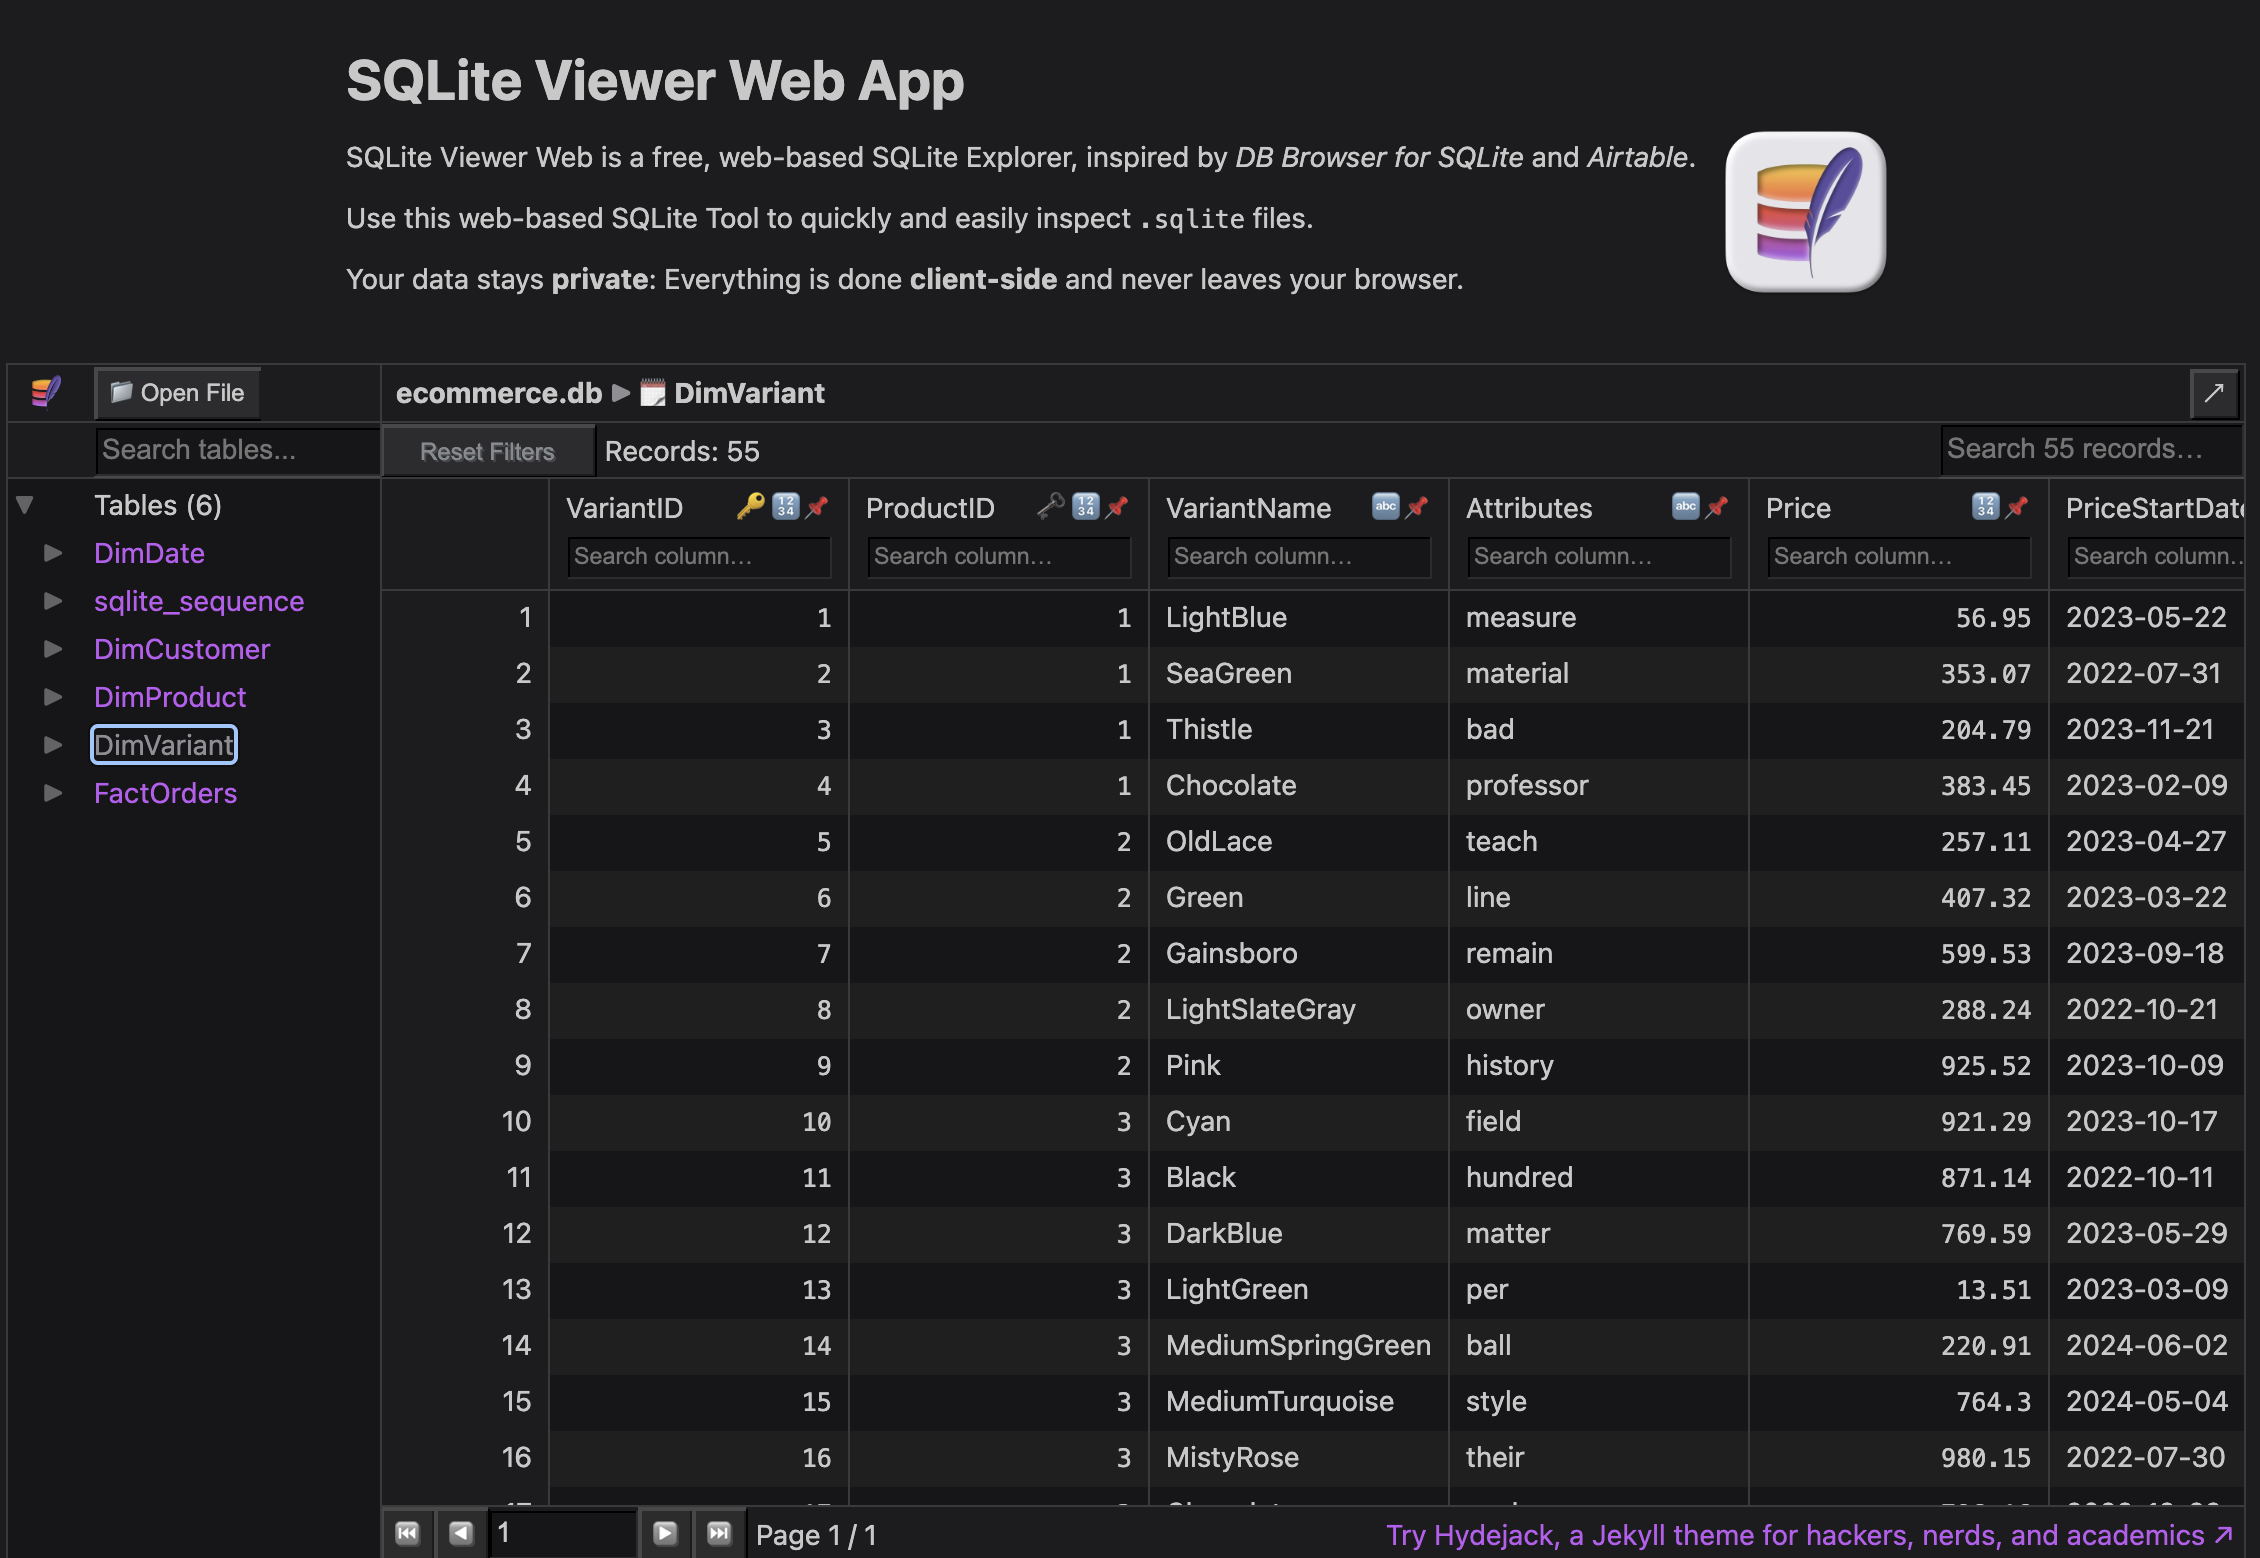

# ERD Diagram 
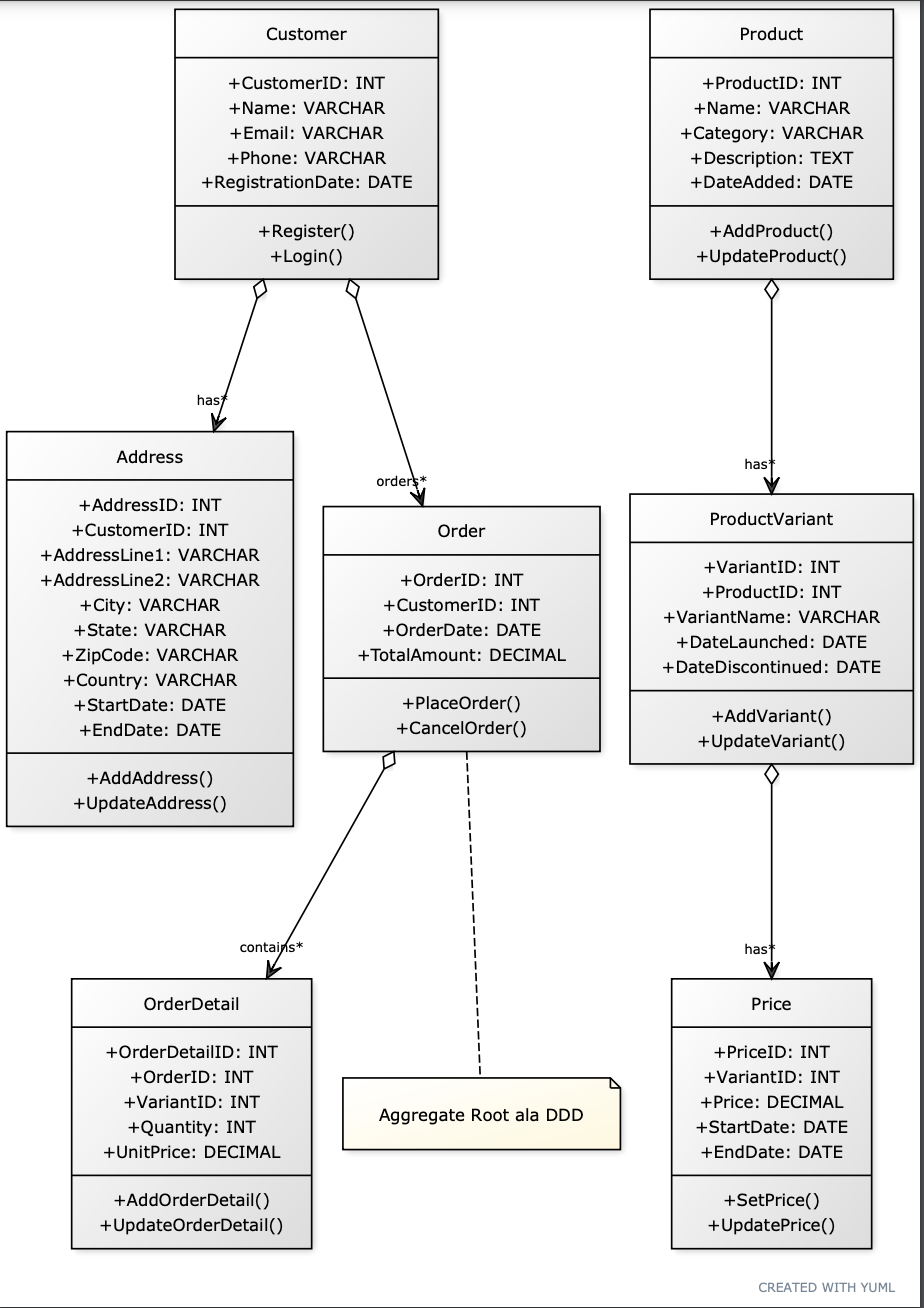

### Problem 2: SQL (related to Problem 1)

With the above data, write SQL queries for the following:

1. Retrieve the top 5 customers who have made the highest average order amounts in the last 6 months. The average order amount should be calculated for each customer, and the result should be sorted in descending order.
2. Retrieve the list of customer whose order value is lower this year as compared to previous year
3. Create a table showing cumulative purchase by a particular customer. Show the breakup of cumulative purchases by product category
4. Retrieve the list of top 5 selling products. Further bifurcate the sales by product variants

In [4]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('ecommerce.db')
cursor = conn.cursor()

# Query 1: Retrieve the top 5 customers who have made the highest average order amounts in the last 6 months
query1 = '''
WITH RecentOrders AS (
    SELECT
        fo.CustomerID,
        fo.TotalPrice
    FROM
        FactOrders fo
    JOIN
        DimDate dd ON fo.OrderDateID = dd.DateID
    WHERE
        dd.Date >= DATE('now', '-6 months')
),
CustomerAvgOrder AS (
    SELECT
        ro.CustomerID,
        AVG(ro.TotalPrice) AS AvgOrderAmount
    FROM
        RecentOrders ro
    GROUP BY
        ro.CustomerID
)
SELECT
    dc.CustomerName,
    dc.ContactNumber,
    cao.AvgOrderAmount
FROM
    CustomerAvgOrder cao
JOIN
    DimCustomer dc ON cao.CustomerID = dc.CustomerID
ORDER BY
    cao.AvgOrderAmount DESC
LIMIT 5;
'''

# Query 2: Retrieve the list of customers whose order value is lower this year compared to the previous year
query2 = '''
WITH YearlyCustomerOrders AS (
    SELECT
        fo.CustomerID,
        strftime('%Y', dd.Date) AS OrderYear,
        SUM(fo.TotalPrice) AS TotalOrderValue
    FROM
        FactOrders fo
    JOIN
        DimDate dd ON fo.OrderDateID = dd.DateID
    GROUP BY
        fo.CustomerID, strftime('%Y', dd.Date)
),
CurrentYearOrders AS (
    SELECT
        CustomerID,
        TotalOrderValue AS CurrentYearTotal
    FROM
        YearlyCustomerOrders
    WHERE
        OrderYear = strftime('%Y', 'now')
),
PreviousYearOrders AS (
    SELECT
        CustomerID,
        TotalOrderValue AS PreviousYearTotal
    FROM
        YearlyCustomerOrders
    WHERE
        OrderYear = strftime('%Y', 'now', '-1 year')
)
SELECT
    dc.CustomerName,
    dc.ContactNumber,
    cyo.CurrentYearTotal,
    pyo.PreviousYearTotal
FROM
    CurrentYearOrders cyo
JOIN
    PreviousYearOrders pyo ON cyo.CustomerID = pyo.CustomerID
JOIN
    DimCustomer dc ON cyo.CustomerID = dc.CustomerID
WHERE
    cyo.CurrentYearTotal < pyo.PreviousYearTotal;
'''

# Query 3: Create a table showing cumulative purchases by a particular customer, broken down by product category
query3 = '''
SELECT
    dc.CustomerName,
    dp.Category,
    SUM(fo.TotalPrice) AS CumulativePurchase
FROM
    FactOrders fo
JOIN
    DimCustomer dc ON fo.CustomerID = dc.CustomerID
JOIN
    DimProduct dp ON fo.ProductID = dp.ProductID
WHERE
    dc.CustomerID = ?  -- Replace with the specific customer ID
GROUP BY
    dc.CustomerName, dp.Category
ORDER BY
    CumulativePurchase DESC;
'''

# Query 4: Retrieve the list of top 5 selling products, further bifurcated by product variants
query4 = '''
WITH ProductSales AS (
    SELECT
        fo.ProductID,
        dp.ProductName,
        dv.VariantID,
        dv.VariantName,
        SUM(fo.Quantity) AS TotalQuantitySold,
        SUM(fo.TotalPrice) AS TotalSales
    FROM
        FactOrders fo
    JOIN
        DimProduct dp ON fo.ProductID = dp.ProductID
    JOIN
        DimVariant dv ON fo.VariantID = dv.VariantID
    GROUP BY
        fo.ProductID, dp.ProductName, dv.VariantID, dv.VariantName
),
TopProducts AS (
    SELECT
        ProductID,
        ProductName,
        SUM(TotalQuantitySold) AS TotalQuantity
    FROM
        ProductSales
    GROUP BY
        ProductID, ProductName
    ORDER BY
        TotalQuantity DESC
    LIMIT 5
)
SELECT
    tp.ProductName,
    ps.VariantName,
    ps.TotalQuantitySold,
    ps.TotalSales
FROM
    TopProducts tp
JOIN
    ProductSales ps ON tp.ProductID = ps.ProductID
ORDER BY
    tp.TotalQuantity DESC, ps.TotalQuantitySold DESC;
'''

# Execute Query 1
print("Query 1: Top 5 Customers with Highest Average Order Amounts in Last 6 Months")
cursor.execute(query1)
rows = cursor.fetchall()
for row in rows:
    print(row)

# Execute Query 2
print("\nQuery 2: Customers with Lower Order Value This Year Compared to Previous Year")
cursor.execute(query2)
rows = cursor.fetchall()
for row in rows:
    print(row)

# Execute Query 3 - Replace the ? with a specific customer ID, e.g., 1
specific_customer_id = 1
print(f"\nQuery 3: Cumulative Purchases by Customer ID {specific_customer_id}, Broken Down by Product Category")
cursor.execute(query3, (specific_customer_id,))
rows = cursor.fetchall()
for row in rows:
    print(row)

# Execute Query 4
print("\nQuery 4: Top 5 Selling Products, Bifurcated by Product Variants")
cursor.execute(query4)
rows = cursor.fetchall()
for row in rows:
    print(row)

# Close the database connection
cursor.close()
conn.close()


Query 1: Top 5 Customers with Highest Average Order Amounts in Last 6 Months

Query 2: Customers with Lower Order Value This Year Compared to Previous Year

Query 3: Cumulative Purchases by Customer ID 1, Broken Down by Product Category
('Todd Colon', 'interesting', 3356.79)
('Todd Colon', 'democratic', 2937.69)
('Todd Colon', 'change', 2689.6800000000003)
('Todd Colon', 'wrong', 2271.06)
('Todd Colon', 'already', 1707.4099999999999)
('Todd Colon', 'another', 1290.82)
('Todd Colon', 'score', 940.67)
('Todd Colon', 'least', 646.71)
('Todd Colon', 'increase', 445.23)
('Todd Colon', 'ten', 11.44)

Query 4: Top 5 Selling Products, Bifurcated by Product Variants
('example', 'DarkCyan', 10, 352.73999999999995)
('example', 'MistyRose', 9, 884.83)
('example', 'Peru', 8, 1399.35)
('example', 'LightCyan', 7, 506.73)
('example', 'Cyan', 6, 1004.5899999999999)
('example', 'SeaGreen', 6, 759.51)
('example', 'Tan', 6, 702.48)
('example', 'CadetBlue', 5, 89.29)
('example', 'Chocolate', 5, 270.24)
('e

### Problem 3: ETL

The below given json file contains data related to orchestra, theirs concerts, works, artists, etc. Since the data is in nested JSON format, its not possible to conduct any analysis on the raw data.

[nested_data](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/98b0fa4b-2a85-40e0-af20-5a2785c55c92/Untitled.json)

You are required to:

1. Load the data and perform transformations to simply the data and store it a normalized manner into smaller tables which are easier to analyze
2. Prepare an ERD of the normalized data tables showing relationships between the various entities
3. Implement the transformation using python (can use libraries) and SQL both and submit two separate solutions

# ERD Diagram
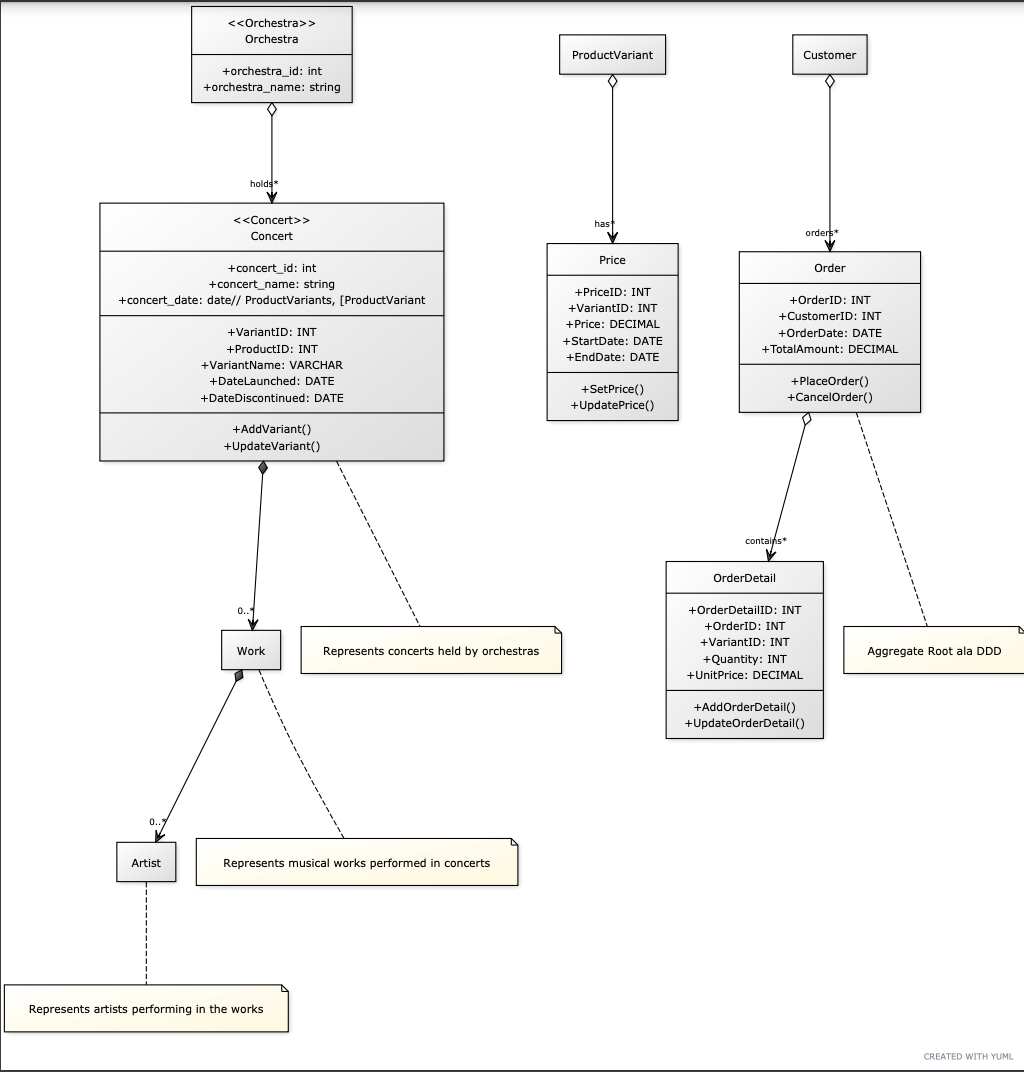

In [41]:
pip install sqlalchemy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
import json
import pandas as pd
with open('nested_data.json') as f:
    data = json.load(f)
import json
import pandas as pd

# Load the JSON data
with open('nested_data.json') as f:
    data = json.load(f)

# Extracting data from the JSON
programs = data['programs']

# Create lists to hold table data
orchestras = []
concerts = []
works = []
soloists = []
composers = []

for program in programs:
    orchestra_id = program['id']
    orchestras.append({
        'orchestra_id': orchestra_id,
        'name': program['orchestra'],
        'season': program['season']
    })
    
    for concert in program['concerts']:
        concert_id = f"{orchestra_id}_{concert['Date']}"
        concerts.append({
            'concert_id': concert_id,
            'orchestra_id': orchestra_id,
            'date': concert['Date'],
            'event_type': concert['eventType'],
            'venue': concert['Venue'],
            'location': concert['Location'],
            'time': concert['Time']
        })
        
        for work in program['works']:
            work_id = work['ID']
            works.append({
                'work_id': work_id,
                'concert_id': concert_id,
                'title': work.get('workTitle', None),
                'composer': work.get('composerName', None),
                'conductor': work.get('conductorName', None),
                'movement': work.get('movement', ''),
                'interval': work.get('interval', '')
            })
            
            if 'soloists' in work:
                for soloist in work['soloists']:
                    soloists.append({
                        'work_id': work_id,
                        'name': soloist.get('soloistName', None),
                        'role': soloist.get('soloistRoles', None),
                        'instrument': soloist.get('soloistInstrument', None)
                    })
            
            if work.get('composerName', None) not in [composer['name'] for composer in composers]:
                composers.append({
                    'name': work.get('composerName', None)
                })

# Convert lists to DataFrames
df_orchestras = pd.DataFrame(orchestras)
df_concerts = pd.DataFrame(concerts)
df_works = pd.DataFrame(works)
df_soloists = pd.DataFrame(soloists)
df_composers = pd.DataFrame(composers)

# Save DataFrames to CSV (optional)
df_orchestras.to_csv('orchestras.csv', index=False)
df_concerts.to_csv('concerts.csv', index=False)
df_works.to_csv('works.csv', index=False)
df_soloists.to_csv('soloists.csv', index=False)
df_composers.to_csv('composers.csv', index=False)
print(df_orchestras)
print(df_concerts)
print(df_works)
print(df_soloists)
print(df_composers)


                               orchestra_id  \
0      38e072a7-8fc9-4f9a-8eac-3957905c0002   
1      c7b2b95c-5e0b-431c-a340-5b37fc860b34   
2      894e1a52-1ae5-4fa7-aec0-b99997555a37   
3      34ec2c2b-3297-4716-9831-b538310462b7   
4      610a4acc-94e4-4cd6-bdc1-8ad020edc7e9   
...                                     ...   
13949  3d50968c-2e8b-405f-969c-ba36f941f393   
13950  adb9fc8b-95bc-47d0-9f4b-78fc242f1f8f   
13951  f072c652-c452-4ad4-975a-f6abd5ff8b4d   
13952  68625626-8085-44e4-bdb3-d8e6ac51c95b   
13953  5c22d35f-a282-4505-bd31-df619c74f52b   

                                           name   season  
0                         New York Philharmonic  1842-43  
1                         New York Philharmonic  1842-43  
2      Musicians from the New York Philharmonic  1842-43  
3                         New York Philharmonic  1842-43  
4                         New York Philharmonic  1843-44  
...                                         ...      ...  
13949  Musicians from 

### Problem 4: Streaming

Download and upload the below json files to a cloud storage (Azure, AWS, GCP) manually 

[json_files.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/7ea8decf-3497-46c4-8095-25ea0a81a40e/json_files.zip)

You are required to:

1. Ingest json files from the cloud storage using Apache Spark Structured Streaming or Databricks Autoloader (read the documentation if you are not familiar with these topics)
2. Write the ingested data to a table without any transformations
3. Infer the schema of the ingested data automatically instead of providing the schema manually
4. Auto-detection of new files in the cloud folder if more json files are added to it.

In [40]:
!pip install pyspark


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder \
    .appName("JSON Ingestion") \
    .getOrCreate()

# Define the cloud storage path
cloud_storage_path = "s3://your-bucket-name/path/to/json/files/"

# Read JSON files using Databricks Autoloader
df = (spark.readStream
      .format("cloudFiles")
      .option("cloudFiles.format", "json")
      .option("cloudFiles.inferColumnTypes", "true")  # Automatically infer schema
      .option("cloudFiles.schemaLocation", "/tmp/schema")  # Path to store the schema
      .load(cloud_storage_path))

# Write ingested data to a table without transformations
(df.writeStream
    .format("delta")
    .option("checkpointLocation", "/tmp/checkpoints")
    .start("/tmp/output_table"))

# Print schema
df.printSchema()


### Problem 5: Time Series

The excel below contains data on the work done by AGI bots who can multi-task and do multiple types of work. They record the start and end time of each task that they undertake along with the name of the activity in this excel file.

[Time Series](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/a5d30693-0a11-417a-a01c-078ea10bea91/Untitled.xlsx)

Since the bots can multi-task and therefore can be doing multiple tasks in parallel, it is not possible to directly determine when they were working and when they were idle. You are required to:

1. Perform transformations on the data to output continuous periods (start, end) of work done by each bot and aggregate the activities done during such periods as an array against each period.
2. Solve the problem using python and SQL both

In [18]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.4/251.4 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [19]:
import pandas as pd
from datetime import timedelta

# Load the data
file_path = 'Time Series.xlsx'
data = pd.read_excel(file_path)

# Convert start and end times to datetime
data['Start'] = pd.to_datetime(data['Start'])
data['End'] = pd.to_datetime(data['End'])

# Function to aggregate continuous work periods
def aggregate_work_periods(df):
    df = df.sort_values(by='Start')
    aggregated_periods = []
    current_start = df.iloc[0]['Start']
    current_end = df.iloc[0]['End']
    current_activities = [df.iloc[0]['Activity']]
    
    for i in range(1, len(df)):
        row = df.iloc[i]
        if row['Start'] <= current_end + timedelta(seconds=1):  # Check if the current period overlaps or is contiguous
            current_end = max(current_end, row['End'])
            current_activities.append(row['Activity'])
        else:
            aggregated_periods.append({'Start': current_start, 'End': current_end, 'Activities': current_activities})
            current_start = row['Start']
            current_end = row['End']
            current_activities = [row['Activity']]
    
    # Append the last period
    aggregated_periods.append({'Start': current_start, 'End': current_end, 'Activities': current_activities})
    return aggregated_periods

# Apply the function to each bot
aggregated_data = data.groupby('Name').apply(aggregate_work_periods).explode().reset_index(drop=True)

# Convert to DataFrame for better readability
aggregated_df = pd.DataFrame(aggregated_data.tolist())
aggregated_df.head()


/var/folders/1d/f1z22y2j3817bxd7llkvs3900000gn/T/ipykernel_53396/1354283380.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_data = data.groupby('Name').apply(aggregate_work_periods).explode().reset_index(drop=True)


,Start,End,Activities
0,2023-03-29 15:31:52.620,2023-10-15 15:31:52.620,"[Reply to Customers, Business Development, Sen..."
1,2023-03-29 15:31:52.620,2023-10-15 13:07:52.620,"[Business Development, Inspection, Fund raisin..."
2,2023-03-29 15:31:52.620,2023-10-15 15:31:52.620,"[Business Development, Remote Inspection, Podc..."
3,2023-03-29 15:31:52.620,2023-10-15 08:19:52.620,"[Call, Call, Fund raising, Call, Inspection, F..."
4,2023-10-15 10:43:52.620,2023-06-28 13:07:52.620,[Reporting]


In [25]:
import pandas as pd
import sqlite3
from datetime import timedelta

# Load the data from the Excel file
file_path = 'Time Series.xlsx'
data = pd.read_excel(file_path)

# Convert start and end times to datetime
data['Start'] = pd.to_datetime(data['Start'])
data['End'] = pd.to_datetime(data['End'])

# Create a SQLite database in memory
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Create the table
cursor.execute('''
CREATE TABLE bot_activity (
    Name TEXT,
    Start TIMESTAMP,
    End TIMESTAMP,
    Activity TEXT
)
''')

# Insert data into the table
for row in data.itertuples(index=False):
    cursor.execute('''
    INSERT INTO bot_activity (Name, Start, End, Activity)
    VALUES (?, ?, ?, ?)
    ''', (row.Name, row.Start.strftime('%Y-%m-%d %H:%M:%S'), row.End.strftime('%Y-%m-%d %H:%M:%S'), row.Activity))

conn.commit()

# Define the SQL query to aggregate work periods
query = '''
WITH RankedActivity AS (
    SELECT 
        Name, 
        Start, 
        End, 
        Activity,
        LAG(End) OVER (PARTITION BY Name ORDER BY Start) AS PrevEnd
    FROM bot_activity
),
AggregatedActivity AS (
    SELECT 
        Name, 
        Start,
        End,
        Activity,
        CASE WHEN Start <= datetime(PrevEnd, '+1 second') THEN 0 ELSE 1 END AS NewPeriod
    FROM RankedActivity
),
GroupedActivity AS (
    SELECT
        Name,
        Start,
        End,
        Activity,
        SUM(NewPeriod) OVER (PARTITION BY Name ORDER BY Start) AS PeriodGroup
    FROM AggregatedActivity
)
SELECT
    Name,
    MIN(Start) AS Start,
    MAX(End) AS End,
    GROUP_CONCAT(Activity) AS Activities
FROM GroupedActivity
GROUP BY Name, PeriodGroup
ORDER BY Name, Start;
'''

# Execute the query and fetch the results
cursor.execute(query)
result = cursor.fetchall()

# Convert the result to a DataFrame for better readability
result_df = pd.DataFrame(result, columns=['Name', 'Start', 'End', 'Activities'])
print(result_df)


        Name                Start                  End  \
0     Deepti  2023-03-29 15:31:52  2023-09-14 10:43:52   
1     Deepti  2023-03-30 17:55:52  2023-10-09 13:07:52   
2     Deepti  2023-04-02 17:55:52  2023-05-06 10:43:52   
3     Deepti  2023-04-02 22:43:52  2023-08-25 05:55:52   
4     Deepti  2023-04-03 13:07:52  2023-08-30 15:31:52   
...      ...                  ...                  ...   
3946  Sharan  2023-10-14 17:55:52  2023-09-03 15:31:52   
3947  Sharan  2023-10-14 22:43:52  2023-09-10 22:43:52   
3948  Sharan  2023-10-15 03:31:52  2023-08-11 03:31:52   
3949  Sharan  2023-10-15 08:19:52  2023-08-14 17:55:52   
3950  Sharan  2023-10-15 15:31:52  2023-07-23 17:55:52   

                                             Activities  
0     Business Development,Reply to Customers,Send E...  
1     Podcast,Podcast,Remote Inspection,Reply to Cus...  
2                                               Updates  
3     Remote Inspection,Reply to Customers,Business ...  
4     Call,Bu